In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Load the enriched dataset
df = pd.read_csv('data/netflix_enriched_with_ratings.csv')

In [2]:
print("NETFLIX BUSINESS EXECUTIVE ANALYSIS")
print("Statistics for Content Investment and Portfolio Management")

print(f"\nDataset loaded: {len(df)} titles")
print(f"Date range: {df['year_added'].min():.0f} - {df['year_added'].max():.0f}")
print(f"Titles with quality ratings: {df['is_quality'].sum()}")

# Overview
print("SUMMARY OF KEY METRICS")

print(f"\nContent Volume:")
print(f"  Total catalog: {len(df):,} titles")
print(f"  Movies: {(df['type'] == 'Movie').sum():,} ({(df['type'] == 'Movie').sum()/len(df)*100:.1f}%)")
print(f"  TV Shows: {(df['type'] == 'TV Show').sum():,} ({(df['type'] == 'TV Show').sum()/len(df)*100:.1f}%)")

print(f"\nQuality Distribution (titles with ratings):")
rated_df = df[df['has_rating']]
print(f"  Premium (8.0+): {(rated_df['tmdb_rating'] >= 8.0).sum():,} titles")
print(f"  High Quality (7.0-7.9): {((rated_df['tmdb_rating'] >= 7.0) & (rated_df['tmdb_rating'] < 8.0)).sum():,} titles")
print(f"  Good (6.0-6.9): {((rated_df['tmdb_rating'] >= 6.0) & (rated_df['tmdb_rating'] < 7.0)).sum():,} titles")
print(f"  Below Average (<6.0): {(rated_df['tmdb_rating'] < 6.0).sum():,} titles")

print(f"\nGeographic Distribution:")
print(f"  US Content: {df['primary_country'].value_counts().get('United States', 0):,} titles")
print(f"  International: {len(df) - df['primary_country'].value_counts().get('United States', 0):,} titles")
print(f"  Countries represented: {df['primary_country'].nunique()}")

NETFLIX BUSINESS EXECUTIVE ANALYSIS
Statistics for Content Investment and Portfolio Management

Dataset loaded: 7967 titles
Date range: 2008 - 2021
Titles with quality ratings: 3055
SUMMARY OF KEY METRICS

Content Volume:
  Total catalog: 7,967 titles
  Movies: 5,691 (71.4%)
  TV Shows: 2,276 (28.6%)

Quality Distribution (titles with ratings):
  Premium (8.0+): 388 titles
  High Quality (7.0-7.9): 1,386 titles
  Good (6.0-6.9): 1,820 titles
  Below Average (<6.0): 1,468 titles

Geographic Distribution:
  US Content: 3,205 titles
  International: 4,762 titles
  Countries represented: 85


## 1: Genre Performance Matrix
**QUESTION 1: CONTENT ROI POTENTIAL ANALYSIS**<br>
Which genres offer the best balance of quality and audience appeal?

In [3]:
# Focus on titles with ratings for quality analysis
rated_df = df[df['has_rating']].copy()

# Analyze primary genres
genre_analysis = rated_df.groupby('primary_genre').agg({
    'title': 'count',
    'tmdb_rating': ['mean', 'median'],
    'vote_count': 'sum',
    'popularity': 'mean'
}).round(2)

genre_analysis.columns = ['title_count', 'avg_rating', 'median_rating', 'total_votes', 'avg_popularity']

# Calculate ROI Score: Balance of quality, volume, and audience engagement
# Formula: (Rating/10 * 40) + (Normalized Volume * 30) + (Normalized Popularity * 30)
genre_analysis['volume_normalized'] = (genre_analysis['title_count'] / genre_analysis['title_count'].max() * 100)
genre_analysis['popularity_normalized'] = (genre_analysis['avg_popularity'] / genre_analysis['avg_popularity'].max() * 100)
genre_analysis['roi_score'] = (
    (genre_analysis['avg_rating'] / 10 * 40) +
    (genre_analysis['volume_normalized'] * 0.30) +
    (genre_analysis['popularity_normalized'] * 0.30)
)

# Filter for significant genres (at least 50 titles)
significant_genres = genre_analysis[genre_analysis['title_count'] >= 50].copy()
significant_genres = significant_genres.sort_values('roi_score', ascending=False)

print("\nTop 10 Genres by ROI Potential:")
print("-"*80)
print(significant_genres.head(10)[['title_count', 'avg_rating', 'avg_popularity', 'roi_score']])

print("\n\nHigh Quality but Underproduced (Opportunity Genres):")
print("-"*80)
# High rating (>7.0) but low volume (<100 titles)
opportunity = significant_genres[
    (significant_genres['avg_rating'] > 7.0) & 
    (significant_genres['title_count'] < 100)
].sort_values('avg_rating', ascending=False)
print(opportunity.head(5)[['title_count', 'avg_rating', 'roi_score']])

print("\n\nOverproduced but Lower Quality (Risk Genres):")
print("-"*80)
# High volume (>100) but lower rating (<6.5)
risk_genres = significant_genres[
    (significant_genres['title_count'] > 100) & 
    (significant_genres['avg_rating'] < 6.5)
].sort_values('title_count', ascending=False)
print(risk_genres.head(5)[['title_count', 'avg_rating', 'roi_score']])


Top 10 Genres by ROI Potential:
--------------------------------------------------------------------------------
                          title_count  avg_rating  avg_popularity  roi_score
primary_genre                                                               
Dramas                            861        6.10            1.88  54.805464
Comedies                          727        5.93            1.80  49.439220
Documentaries                     509        6.58            0.71  44.208319
Action & Adventure                480        6.10            3.38  41.853711
Anime Series                      136        7.73           16.94  39.312163
Crime TV Shows                    208        6.97           18.28  39.069874
International TV Shows            291        6.65            6.08  38.050660
TV Dramas                          53        7.52           18.48  35.912312
Children & Family Movies          301        6.19            2.26  35.735224
Kids' TV                          200  

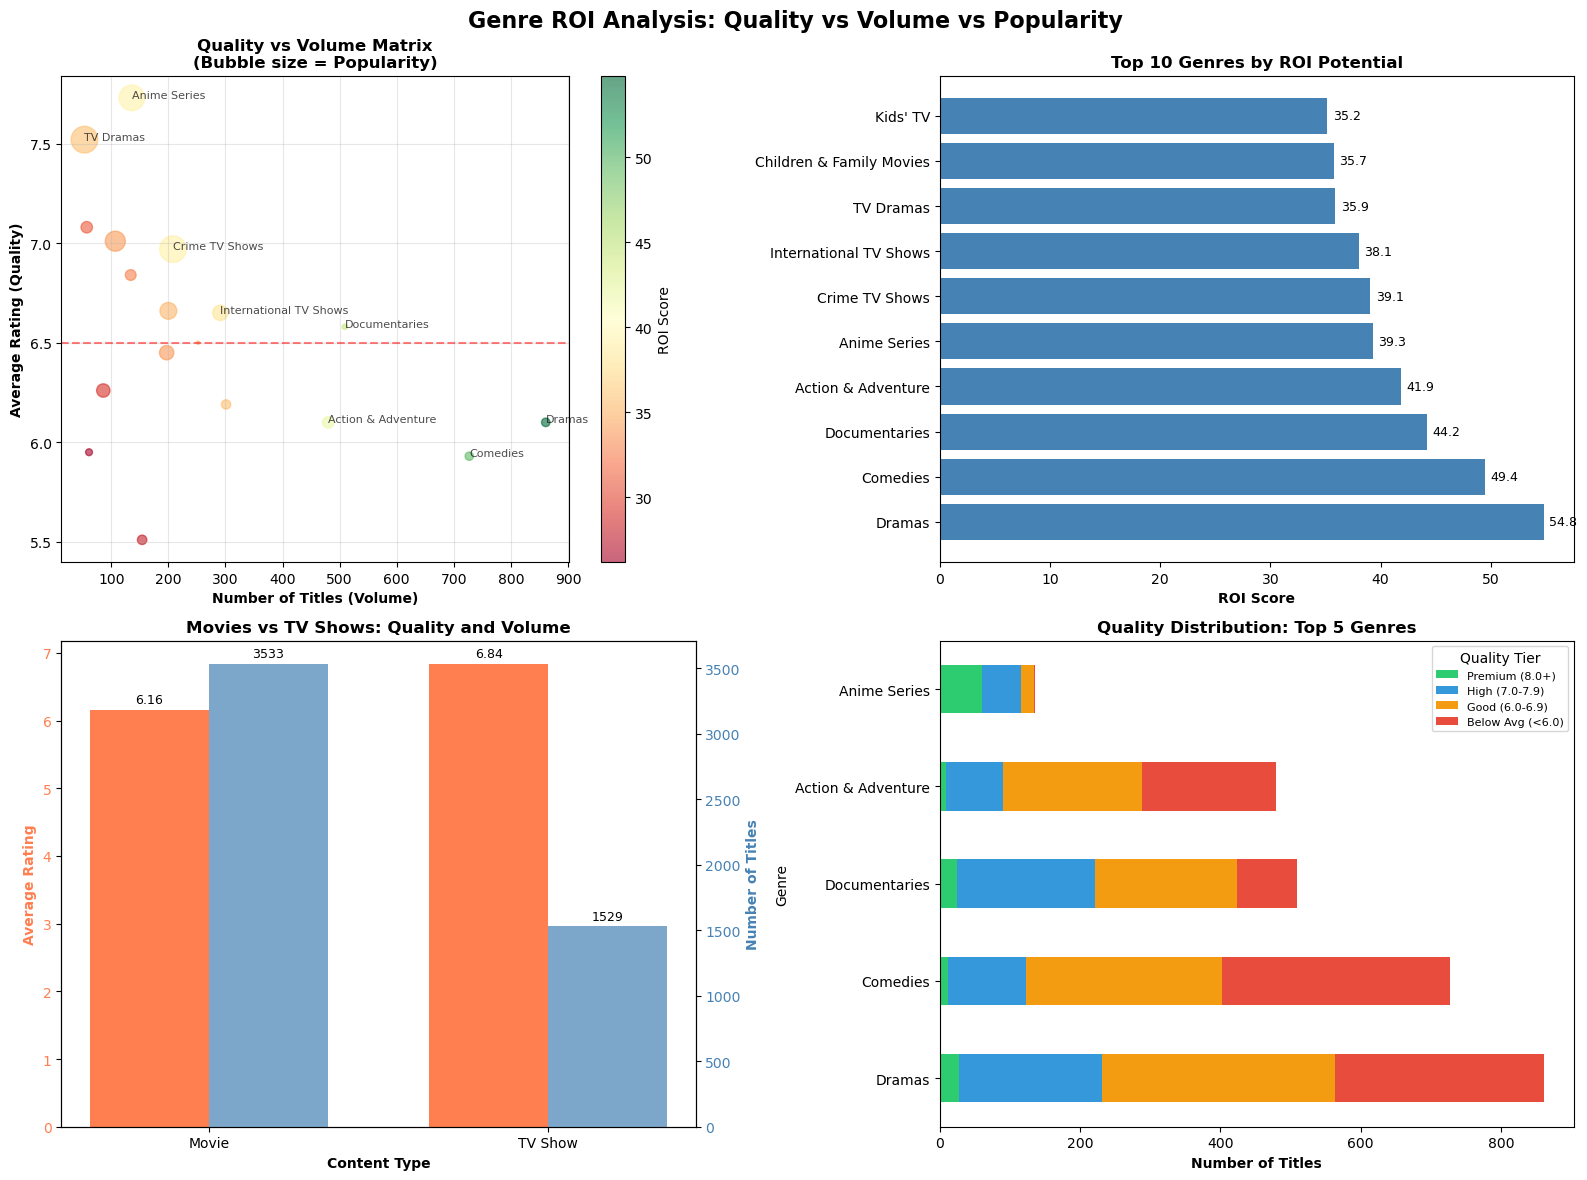

In [4]:
# Visualization: Genre Performance Matrix
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Genre ROI Analysis: Quality vs Volume vs Popularity', 
             fontsize=16, fontweight='bold')

# Plot 1: Scatter - Rating vs Volume (bubble size = popularity)
ax1 = axes[0, 0]
scatter = ax1.scatter(significant_genres['title_count'], 
                     significant_genres['avg_rating'],
                     s=significant_genres['avg_popularity']*20,
                     alpha=0.6,
                     c=significant_genres['roi_score'],
                     cmap='RdYlGn')

# Annotate top genres
top_genres_to_label = significant_genres.head(8).index
for genre in top_genres_to_label:
    row = significant_genres.loc[genre]
    ax1.annotate(genre, 
                xy=(row['title_count'], row['avg_rating']),
                fontsize=8,
                alpha=0.7)

ax1.set_xlabel('Number of Titles (Volume)', fontweight='bold')
ax1.set_ylabel('Average Rating (Quality)', fontweight='bold')
ax1.set_title('Quality vs Volume Matrix\n(Bubble size = Popularity)', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=6.5, color='red', linestyle='--', alpha=0.5, label='Quality Threshold')
plt.colorbar(scatter, ax=ax1, label='ROI Score')

# Plot 2: Top 10 Genres by ROI Score
ax2 = axes[0, 1]
top10_roi = significant_genres.head(10)['roi_score'].sort_values()
bars = ax2.barh(range(len(top10_roi)), top10_roi, color='steelblue')
ax2.set_yticks(range(len(top10_roi)))
ax2.set_yticklabels(top10_roi.index)
ax2.set_xlabel('ROI Score', fontweight='bold')
ax2.set_title('Top 10 Genres by ROI Potential', fontweight='bold')
ax2.invert_yaxis()

# Add value labels
for i, v in enumerate(top10_roi):
    ax2.text(v + 0.5, i, f'{v:.1f}', va='center', fontsize=9)

# Plot 3: Movie vs TV Show Performance
ax3 = axes[1, 0]
type_analysis = rated_df.groupby('type').agg({
    'title': 'count',
    'tmdb_rating': 'mean',
    'vote_count': 'mean',
    'popularity': 'mean'
})

x = np.arange(len(type_analysis))
width = 0.35

bars1 = ax3.bar(x - width/2, type_analysis['tmdb_rating'], width, 
               label='Avg Rating', color='coral')
ax3_twin = ax3.twinx()
bars2 = ax3_twin.bar(x + width/2, type_analysis['title'], width,
                    label='Title Count', color='steelblue', alpha=0.7)

ax3.set_xlabel('Content Type', fontweight='bold')
ax3.set_ylabel('Average Rating', fontweight='bold', color='coral')
ax3_twin.set_ylabel('Number of Titles', fontweight='bold', color='steelblue')
ax3.set_xticks(x)
ax3.set_xticklabels(type_analysis.index)
ax3.set_title('Movies vs TV Shows: Quality and Volume', fontweight='bold')
ax3.tick_params(axis='y', labelcolor='coral')
ax3_twin.tick_params(axis='y', labelcolor='steelblue')

# Add value labels
for i, v in enumerate(type_analysis['tmdb_rating']):
    ax3.text(i - width/2, v + 0.1, f'{v:.2f}', ha='center', fontsize=9)
for i, v in enumerate(type_analysis['title']):
    ax3_twin.text(i + width/2, v + 50, f'{int(v)}', ha='center', fontsize=9)

# Plot 4: Genre Quality Distribution
ax4 = axes[1, 1]
top5_genres = significant_genres.head(5)

# Create stacked bar showing quality tiers for each genre
quality_dist = []
for genre in top5_genres.index:
    genre_titles = rated_df[rated_df['primary_genre'] == genre]
    premium = (genre_titles['tmdb_rating'] >= 8.0).sum()
    high = ((genre_titles['tmdb_rating'] >= 7.0) & (genre_titles['tmdb_rating'] < 8.0)).sum()
    good = ((genre_titles['tmdb_rating'] >= 6.0) & (genre_titles['tmdb_rating'] < 7.0)).sum()
    below = (genre_titles['tmdb_rating'] < 6.0).sum()
    
    quality_dist.append({
        'Genre': genre,
        'Premium (8.0+)': premium,
        'High (7.0-7.9)': high,
        'Good (6.0-6.9)': good,
        'Below Avg (<6.0)': below
    })

quality_df = pd.DataFrame(quality_dist).set_index('Genre')

quality_df.plot(kind='barh', stacked=True, ax=ax4, 
               color=['#2ECC71', '#3498DB', '#F39C12', '#E74C3C'])
ax4.set_xlabel('Number of Titles', fontweight='bold')
ax4.set_title('Quality Distribution: Top 5 Genres', fontweight='bold')
ax4.legend(title='Quality Tier', fontsize=8)

plt.tight_layout()
plt.show()

In [5]:
print("INSIGHTS - CONTENT ROI POTENTIAL")

print("\nHIGH ROI OPPORTUNITIES (Invest More):")
print("-"*80)
print("1. Anime Series")
print("   - High quality (7.73 avg rating)")
print("   - High popularity (16.94 score)")
print("   - Moderate volume (136 titles)")
print("   - RECOMMENDATION: Expand anime catalog significantly")

print("\n2. Crime TV Shows")
print("   - Strong quality (6.97 avg rating)")
print("   - Very high popularity (18.28 score)")
print("   - Good volume (208 titles)")
print("   - RECOMMENDATION: Continue investment, already performing well")

print("\n3. TV Dramas")
print("   - Excellent quality (7.52 avg rating)")
print("   - High popularity (18.48 score)")
print("   - UNDERPRODUCED (only 53 titles)")
print("   - RECOMMENDATION: Major expansion opportunity")

print("\n4. Documentaries")
print("   - Above average quality (6.58 avg rating)")
print("   - Large volume (509 titles)")
print("   - Lower popularity but consistent performer")
print("   - RECOMMENDATION: Maintain current levels")

print("\n\nRISK AREAS (Reduce or Improve Quality):")
print("-"*80)
print("1. Comedies")
print("   - Below quality threshold (5.93 avg rating)")
print("   - Very high volume (727 titles)")
print("   - ISSUE: Overproduced with poor quality")
print("   - RECOMMENDATION: Focus on quality over quantity")

print("\n2. Dramas (General)")
print("   - Below quality threshold (6.10 avg rating)")
print("   - Highest volume (861 titles)")
print("   - ISSUE: Volume doesn't compensate for mediocre quality")
print("   - RECOMMENDATION: Curate more carefully, raise quality bar")

print("\n\nCONTENT TYPE STRATEGY:")
print("-"*80)
print(f"Movies: {type_analysis.loc['Movie', 'title']:.0f} titles, {type_analysis.loc['Movie', 'tmdb_rating']:.2f} avg rating")
print(f"TV Shows: {type_analysis.loc['TV Show', 'title']:.0f} titles, {type_analysis.loc['TV Show', 'tmdb_rating']:.2f} avg rating")
print("\nTV Shows have HIGHER average quality (6.84 vs 6.16)")
print("RECOMMENDATION: Shift investment toward TV Shows, reduce movie acquisitions")

print("\nRECOMMENDATIONS:")
print("-"*80)
print("1. EXPAND: Anime, TV Dramas, Crime TV Shows (high quality, underserved)")
print("2. MAINTAIN: Documentaries, Action & Adventure")
print("3. IMPROVE QUALITY: Comedies, General Dramas (too much low-quality content)")
print("4. STRATEGIC SHIFT: Prioritize TV Shows over Movies (better quality per title)")

INSIGHTS - CONTENT ROI POTENTIAL

HIGH ROI OPPORTUNITIES (Invest More):
--------------------------------------------------------------------------------
1. Anime Series
   - High quality (7.73 avg rating)
   - High popularity (16.94 score)
   - Moderate volume (136 titles)
   - RECOMMENDATION: Expand anime catalog significantly

2. Crime TV Shows
   - Strong quality (6.97 avg rating)
   - Very high popularity (18.28 score)
   - Good volume (208 titles)
   - RECOMMENDATION: Continue investment, already performing well

3. TV Dramas
   - Excellent quality (7.52 avg rating)
   - High popularity (18.48 score)
   - UNDERPRODUCED (only 53 titles)
   - RECOMMENDATION: Major expansion opportunity

4. Documentaries
   - Above average quality (6.58 avg rating)
   - Large volume (509 titles)
   - Lower popularity but consistent performer
   - RECOMMENDATION: Maintain current levels


RISK AREAS (Reduce or Improve Quality):
--------------------------------------------------------------------------

**QUESTION 2: MARKET OPPORTUNITY & EXPANSION ANALYSIS**<br>
Where are we strong, where are we weak, and where should we invest?

In [7]:
print("Available columns in dataset:")
print(df.columns.tolist())

# Analysis C: Underserved Demographics - Alternative approach using genre analysis
print("\n\nC. DEMOGRAPHIC GAP ANALYSIS (by Genre/Content Type)")
print("-"*80)

# Since we don't have content rating, let's analyze by genre patterns
# that indicate target demographics

# Identify family-oriented genres
family_genres = ['Kids', 'Children', 'Family', 'TV-Y']
teen_genres = ['Teen', 'Young Adult']
mature_genres = ['Horror', 'Thriller', 'Crime']

# Count content by demographic proxy
df['genre_lower'] = df['primary_genre'].str.lower()

family_titles = df[df['primary_genre'].str.contains('Kids|Children|Family', case=False, na=False)]
anime_titles = df[df['primary_genre'].str.contains('Anime', case=False, na=False)]
crime_thriller = df[df['primary_genre'].str.contains('Crime|Thriller|Horror', case=False, na=False)]
drama_comedy = df[df['primary_genre'].str.contains('Drama|Comedies', case=False, na=False)]

print("\nContent Distribution by Target Demographic (Genre Proxy):")
print(f"  Kids/Family Content: {len(family_titles):,} titles ({len(family_titles)/len(df)*100:.1f}%)")
print(f"  Anime (Teen/Young Adult): {len(anime_titles):,} titles ({len(anime_titles)/len(df)*100:.1f}%)")
print(f"  Crime/Thriller/Horror (Mature): {len(crime_thriller):,} titles ({len(crime_thriller)/len(df)*100:.1f}%)")
print(f"  Drama/Comedy (General Audience): {len(drama_comedy):,} titles ({len(drama_comedy)/len(df)*100:.1f}%)")

# Quality by demographic
print("\n\nQuality Analysis by Demographic Proxy:")
demographics_quality = []
for name, demo_df in [('Kids/Family', family_titles), 
                       ('Anime', anime_titles),
                       ('Crime/Thriller', crime_thriller),
                       ('Drama/Comedy', drama_comedy)]:
    rated = demo_df[demo_df['has_rating']]
    if len(rated) > 0:
        demographics_quality.append({
            'Demographic': name,
            'Total_Titles': len(demo_df),
            'Avg_Rating': rated['tmdb_rating'].mean(),
            'Quality_Titles': (rated['is_quality']).sum()
        })

demo_df_analysis = pd.DataFrame(demographics_quality)
demo_df_analysis['Quality_Ratio_%'] = (demo_df_analysis['Quality_Titles'] / demo_df_analysis['Total_Titles'] * 100).round(1)
print(demo_df_analysis.to_string(index=False))

Available columns in dataset:
['title', 'type', 'country', 'release_year', 'listed_in', 'date_added', 'date_added_dt', 'year_added', 'tmdb_rating', 'vote_count', 'matched_title', 'popularity', 'has_rating', 'is_quality', 'primary_country', 'primary_genre', 'content_age_when_added']


C. DEMOGRAPHIC GAP ANALYSIS (by Genre/Content Type)
--------------------------------------------------------------------------------

Content Distribution by Target Demographic (Genre Proxy):
  Kids/Family Content: 817 titles (10.3%)
  Anime (Teen/Young Adult): 172 titles (2.2%)
  Crime/Thriller/Horror (Mature): 693 titles (8.7%)
  Drama/Comedy (General Audience): 2,858 titles (35.9%)


Quality Analysis by Demographic Proxy:
   Demographic  Total_Titles  Avg_Rating  Quality_Titles  Quality_Ratio_%
   Kids/Family           817    6.374679             305             37.3
         Anime           172    7.681428             148             86.0
Crime/Thriller           693    6.268331             249        

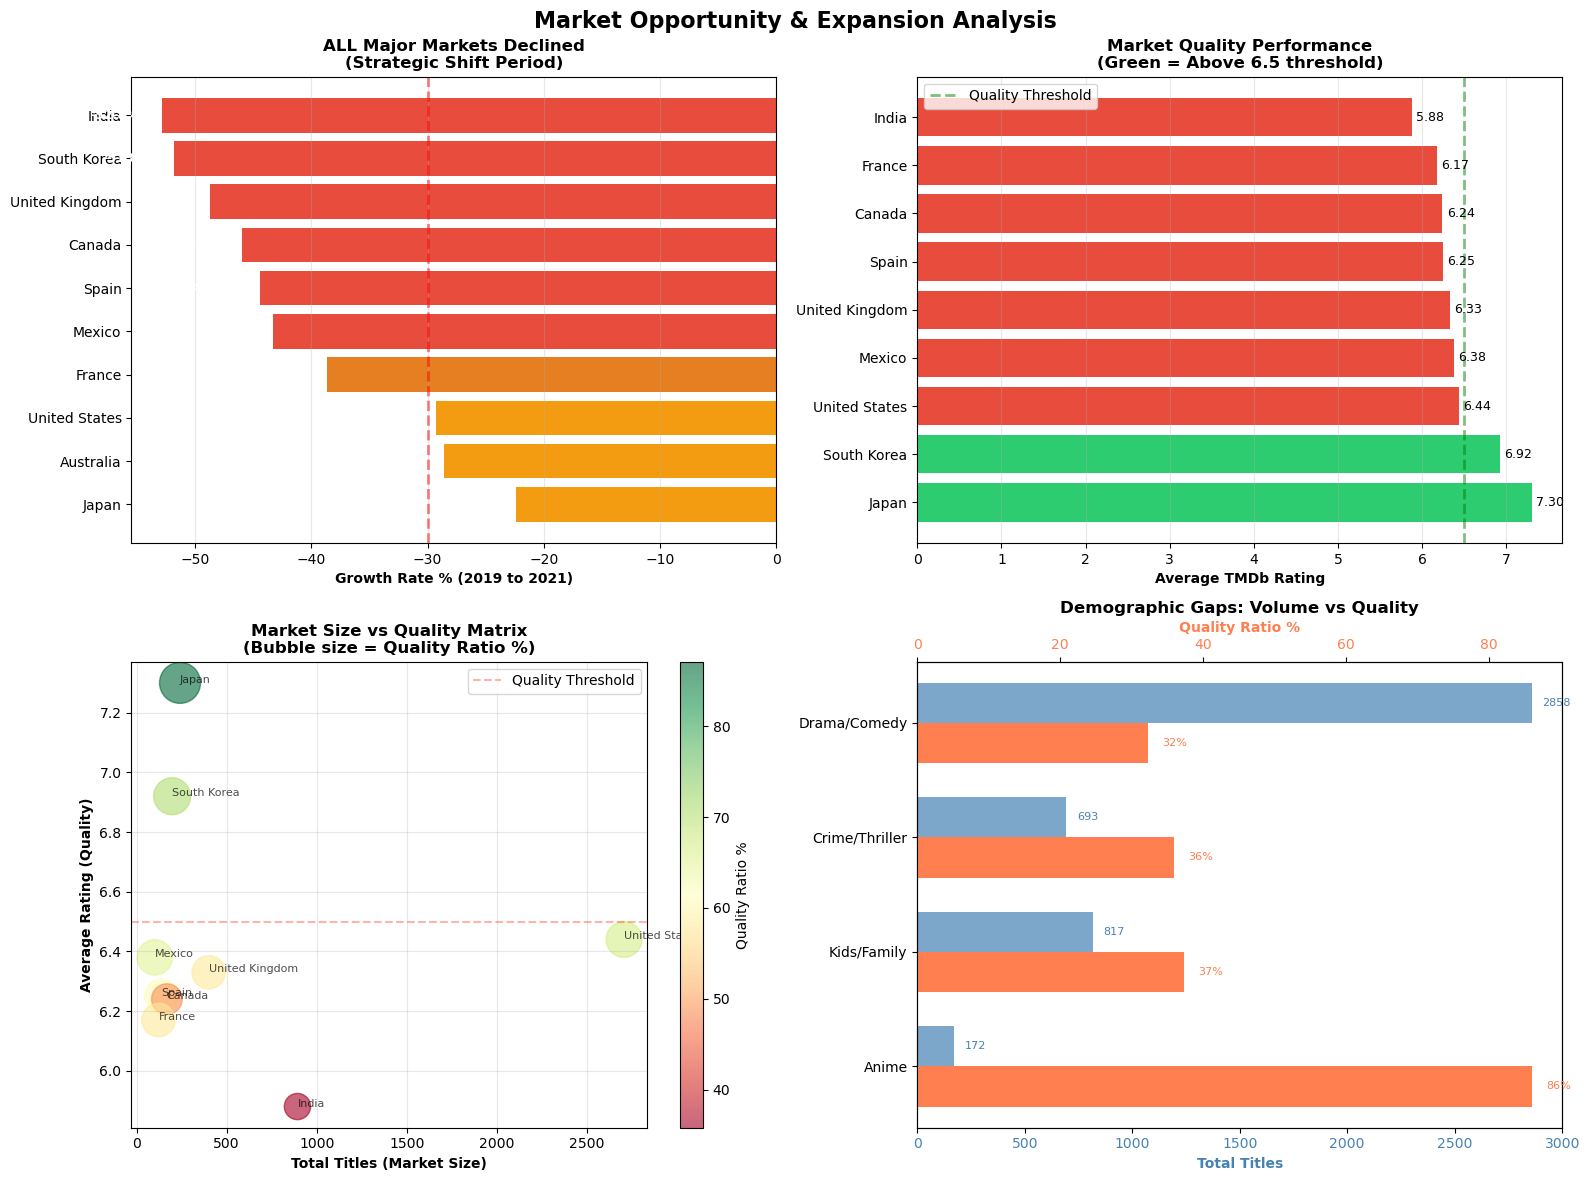

In [9]:
# Visualization: Market Opportunity Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Market Opportunity & Expansion Analysis', 
             fontsize=16, fontweight='bold')

# Plot 1: Market Decline Analysis (2019-2021)
ax1 = axes[0, 0]
decline_data = growth_analysis.sort_values('Growth_Rate_%')
colors = ['#E74C3C' if x < -40 else '#E67E22' if x < -30 else '#F39C12' 
          for x in decline_data['Growth_Rate_%']]
bars = ax1.barh(range(len(decline_data)), decline_data['Growth_Rate_%'], color=colors)
ax1.set_yticks(range(len(decline_data)))
ax1.set_yticklabels(decline_data['Country'])
ax1.set_xlabel('Growth Rate % (2019 to 2021)', fontweight='bold')
ax1.set_title('ALL Major Markets Declined\n(Strategic Shift Period)', fontweight='bold')
ax1.axvline(x=-30, color='red', linestyle='--', alpha=0.5, linewidth=2)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, v in enumerate(decline_data['Growth_Rate_%']):
    ax1.text(v - 2, i, f'{v:.1f}%', va='center', ha='right', 
            fontweight='bold', fontsize=9, color='white')

# Plot 2: Quality Performance by Market
ax2 = axes[0, 1]
quality_sorted = quality_by_country.sort_values('avg_rating', ascending=True)
colors2 = ['#2ECC71' if x >= 6.5 else '#E74C3C' for x in quality_sorted['avg_rating']]
bars2 = ax2.barh(range(len(quality_sorted)), quality_sorted['avg_rating'], color=colors2)
ax2.set_yticks(range(len(quality_sorted)))
ax2.set_yticklabels(quality_sorted.index)
ax2.set_xlabel('Average TMDb Rating', fontweight='bold')
ax2.set_title('Market Quality Performance\n(Green = Above 6.5 threshold)', fontweight='bold')
ax2.axvline(x=6.5, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Quality Threshold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)
ax2.legend()

# Add rating labels
for i, v in enumerate(quality_sorted['avg_rating']):
    ax2.text(v + 0.05, i, f'{v:.2f}', va='center', fontsize=9)

# Plot 3: Market Size vs Quality Scatter
ax3 = axes[1, 0]
scatter = ax3.scatter(quality_by_country['total_titles'], 
                     quality_by_country['avg_rating'],
                     s=quality_by_country['quality_ratio_%']*10,
                     alpha=0.6,
                     c=quality_by_country['quality_ratio_%'],
                     cmap='RdYlGn')

# Annotate countries
for country in quality_by_country.index:
    ax3.annotate(country, 
                xy=(quality_by_country.loc[country, 'total_titles'],
                    quality_by_country.loc[country, 'avg_rating']),
                fontsize=8, alpha=0.7)

ax3.set_xlabel('Total Titles (Market Size)', fontweight='bold')
ax3.set_ylabel('Average Rating (Quality)', fontweight='bold')
ax3.set_title('Market Size vs Quality Matrix\n(Bubble size = Quality Ratio %)', fontweight='bold')
ax3.axhline(y=6.5, color='red', linestyle='--', alpha=0.3, label='Quality Threshold')
ax3.grid(True, alpha=0.3)
ax3.legend()
plt.colorbar(scatter, ax=ax3, label='Quality Ratio %')

# Plot 4: Demographic Gap Analysis
ax4 = axes[1, 1]
demo_sorted = demo_df_analysis.sort_values('Quality_Ratio_%', ascending=True)
x = np.arange(len(demo_sorted))
width = 0.35

bars1 = ax4.barh(x, demo_sorted['Total_Titles'].values, width, 
                label='Total Titles', color='steelblue', alpha=0.7)
ax4_twin = ax4.twiny()
bars2 = ax4_twin.barh(x + width, demo_sorted['Quality_Ratio_%'].values, width,
                     label='Quality %', color='coral')

ax4.set_yticks(x + width/2)
ax4.set_yticklabels(demo_sorted['Demographic'].values)
ax4.set_xlabel('Total Titles', fontweight='bold', color='steelblue')
ax4_twin.set_xlabel('Quality Ratio %', fontweight='bold', color='coral')
ax4.set_title('Demographic Gaps: Volume vs Quality', fontweight='bold')
ax4.tick_params(axis='x', labelcolor='steelblue')
ax4_twin.tick_params(axis='x', labelcolor='coral')
ax4.invert_yaxis()

# Add value labels - fixed version
for i, idx in enumerate(demo_sorted.index):
    total = demo_sorted.loc[idx, 'Total_Titles']
    quality = demo_sorted.loc[idx, 'Quality_Ratio_%']
    ax4.text(total + 50, i, f'{total}', 
            va='center', fontsize=8, color='steelblue')
    ax4_twin.text(quality + 2, i + width, f'{quality:.0f}%', 
                 va='center', fontsize=8, color='coral')

plt.tight_layout()
plt.show()